In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
from scipy.special import softmax
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split


In [4]:
df = pd.read_csv("/content/hogwarts_legacy_reviews.csv")

In [5]:
df = df.head(500)

In [6]:
df.head()

,Unnamed: 0,Playtime,Feedback,Review
0,0,16,Positive,Greattt Game!
1,1,26,Positive,9/10Fantastic experience. A true Wizarding Wor...
2,2,29,Positive,worth it
3,3,24,Positive,I've been waiting 84 YEARSSSSSSSS.The game is ...
4,4,7,Positive,very fun game (it is not transphobic at all)


In [7]:
counts = df.groupby('Feedback').count()['Review']

In [8]:
counts

Feedback
Negative     51
Positive    449
Name: Review, dtype: int64

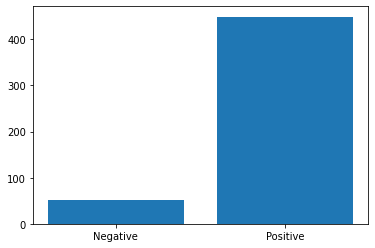

In [9]:
plt.bar(counts.index, counts.values)
plt.show()

In [10]:
df = df[["Feedback", "Review"]]

In [11]:
df.head()

,Feedback,Review
0,Positive,Greattt Game!
1,Positive,9/10Fantastic experience. A true Wizarding Wor...
2,Positive,worth it
3,Positive,I've been waiting 84 YEARSSSSSSSS.The game is ...
4,Positive,very fun game (it is not transphobic at all)


In [12]:
train_dataset, test_dataset = load_dataset("csv", data_files="/content/hogwarts_legacy_reviews.csv", split=['train[:80%]', 'train[-20%:]'])

  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
train_dataset, test_dataset

(Dataset({
     features: ['Unnamed: 0', 'Playtime', 'Feedback', 'Review'],
     num_rows: 37123
 }), Dataset({
     features: ['Unnamed: 0', 'Playtime', 'Feedback', 'Review'],
     num_rows: 9281
 }))

In [14]:
train_dataset = train_dataset.rename_column("Feedback", "labels")


In [15]:
test_dataset = test_dataset.rename_column("Feedback", "labels")

In [16]:
test_dataset

Dataset({
    features: ['Unnamed: 0', 'Playtime', 'labels', 'Review'],
    num_rows: 9281
})

In [17]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
tokenize_func = lambda sentences: tokenizer(sentences['Review'], \
                                           padding="max_length", \
                                           truncation=True)


In [18]:
tokenized_train_dataset = train_dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/37123 [00:00<?, ? examples/s]

In [19]:
tokenized_test_dataset = test_dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/9281 [00:00<?, ? examples/s]

In [20]:
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

In [21]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [22]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [23]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
# We are going to get multiple loss values on each training step here
trainer.evaluate()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Playtime, Review, Unnamed: 0. If Playtime, Review, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 37123
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11605
  Number of trainable parameters = 82119938


ValueError: ignored